In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.models as models

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path  = '/content/drive/MyDrive/Projects/HDA Proj/mini_dataset'

In [5]:
class OCTDataLoader:
    def __init__(self, data_dir, img_size=(224, 224), batch_size=64):
        self.data_dir = data_dir
        self.img_size = img_size
        self.batch_size = batch_size
        self.train_transform = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        self.test_transform = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def get_loaders(self):
        # Load train and test datasets with appropriate transformations
        try:
            train_dataset = datasets.ImageFolder(f'{self.data_dir}/train', transform=self.train_transform)
            test_dataset = datasets.ImageFolder(f'{self.data_dir}/test', transform=self.test_transform)
        except FileNotFoundError as e:
            print("Error: One of the required directories or files is missing.")
            raise e

        # Create data loaders for training and testing
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2, pin_memory=True)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2, pin_memory=True)

        return train_loader, test_loader

In [6]:
# Usage example
data_loader = OCTDataLoader(data_dir=path, img_size=(224, 224), batch_size=96)
train_loader, test_loader = data_loader.get_loaders()

In [7]:
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # Change shape from CxHxW to HxWxC
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Denormalize
    img = np.clip(img, 0, 1)  # Clip values to make sure they are between 0 and 1
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [8]:
# data_iter = iter(train_loader)
# images, labels = next(data_iter)
# print(f"Label: {labels[0]}")
# imshow(images[0])

In [9]:
class OCTDenseNetModel:
    def __init__(self, num_classes=4, learning_rate=0.001):
        # Load pretrained DenseNet121 model
        self.model = models.densenet121(pretrained=True)

        # Modify the classifier layer
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, num_classes)

        # Define loss function and optimizer
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)

    def get_model(self):
        return self.model, self.criterion, self.optimizer

In [10]:
import torch
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.optim.lr_scheduler import CosineAnnealingLR

class TrainModel:
    def __init__(self, model, criterion, optimizer, scheduler, device):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device

    def train(self, train_loader, epochs=10):
        self.model.train()

        train_losses = []
        train_accuracies = []

        # Training loop
        for epoch in range(epochs):
            epoch_loss = 0.0
            correct_predictions = 0
            total_predictions = 0

            start_time = time.time()

            # TQDM progress bar for batch processing
            with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:
                for images, labels in train_loader:
                    images, labels = images.to(self.device), labels.to(self.device)

                    # Zero the parameter gradients
                    self.optimizer.zero_grad()

                    # Forward pass
                    outputs = self.model(images)
                    loss = self.criterion(outputs, labels)

                    # Backward pass and optimize
                    loss.backward()
                    self.optimizer.step()

                    # Update loss and accuracy metrics
                    epoch_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    correct_predictions += (predicted == labels).sum().item()
                    total_predictions += labels.size(0)

                    # Update the progress bar
                    pbar.set_postfix(loss=loss.item())
                    pbar.update(1)

            # Compute epoch metrics
            epoch_loss /= len(train_loader)
            epoch_accuracy = 100 * correct_predictions / total_predictions
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_accuracy)

            # Print epoch metrics
            epoch_time = time.time() - start_time
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Time: {epoch_time:.2f}s")

            # Step the scheduler
            self.scheduler.step()

            # Live plotting
            clear_output(wait=True)
            plt.figure(figsize=(12, 5))

            # Plot Loss
            plt.subplot(1, 2, 1)
            plt.plot(range(1, epoch + 2), train_losses, 'b-', label='Train Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Training Loss')
            plt.legend()

            # Plot Accuracy
            plt.subplot(1, 2, 2)
            plt.plot(range(1, epoch + 2), train_accuracies, 'g-', label='Train Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy (%)')
            plt.title('Training Accuracy')
            plt.legend()

            plt.show()

# Setting up model, criterion, optimizer, and scheduler with the best hyperparameters
learning_rate = 0.0001


In [11]:
# Initialize model
oct_model = OCTDenseNetModel(num_classes=4, learning_rate=learning_rate)
model, criterion, optimizer = oct_model.get_model()

# Add Cosine Annealing Learning Rate Scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-6)

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 150MB/s]


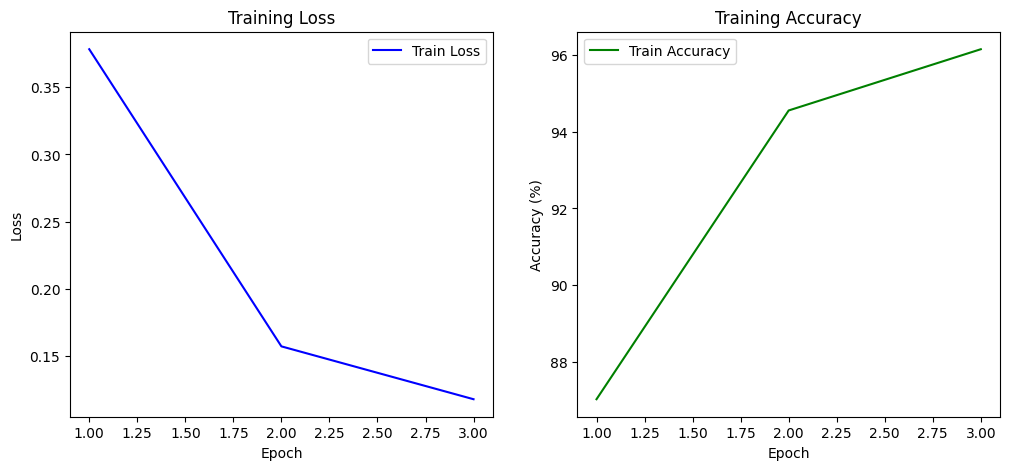

In [12]:
trainer = TrainModel(model, criterion, optimizer, scheduler, device)

# Train model
trainer.train(train_loader, epochs=3)


In [15]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

class ModelEvaluator:
    def __init__(self, model, test_loader, device):
        self.model = model
        self.test_loader = test_loader
        self.device = device

    def evaluate(self):
        self.model.eval()  # Set model to evaluation mode

        all_preds = []
        all_labels = []

        # Disable gradient computation
        with torch.no_grad():
            for images, labels in self.test_loader:
                images, labels = images.to(self.device), labels.to(self.device)

                # Forward pass
                outputs = self.model(images)
                _, preds = torch.max(outputs, 1)

                # Collect predictions and true labels
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Convert to numpy arrays
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)

        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')

        # Print metrics
        print(f"Test Accuracy: {accuracy * 100:.2f}%")
        print(f"Weighted Precision: {precision:.4f}")
        print(f"Weighted Recall: {recall:.4f}")
        print(f"Weighted F1 Score: {f1:.4f}")

        # Plot confusion matrix
        self.plot_confusion_matrix(all_labels, all_preds)

    def plot_confusion_matrix(self, true_labels, pred_labels):
        cm = confusion_matrix(true_labels, pred_labels)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['CNV', 'Druse', 'Normal', 'DME'],
                    yticklabels=['CNV','DME', 'Druse', 'Normal'])
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()



Test Accuracy: 99.00%
Weighted Precision: 0.9904
Weighted Recall: 0.9900
Weighted F1 Score: 0.9900


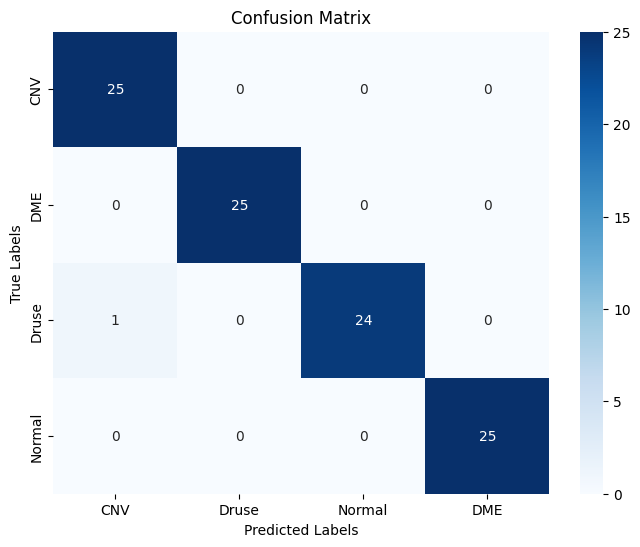

In [16]:
# Usage
evaluator = ModelEvaluator(model, test_loader, device)
evaluator.evaluate()


Test Accuracy: 99.00%
Weighted Precision: 0.9904
Weighted Recall: 0.9900
Weighted F1 Score: 0.9900


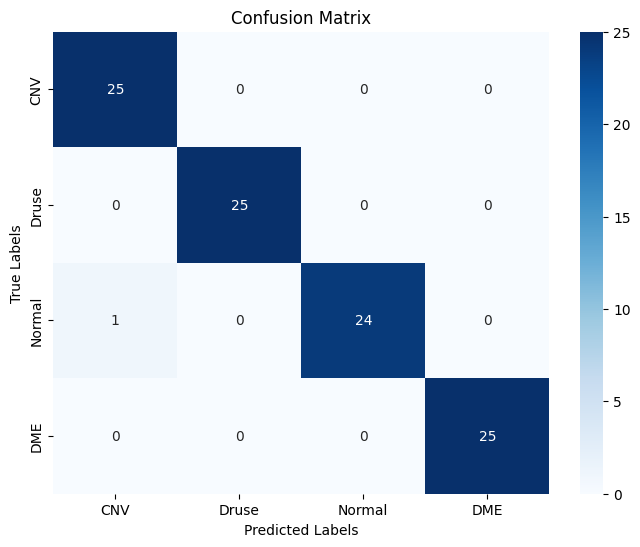

In [14]:
# Usage
evaluator = ModelEvaluator(model, test_loader, device)
evaluator.evaluate()


In [17]:
# Save the trained model after training
model_save_path = "DenseNet_oct_mini_model.pth"
torch.save(trainer.model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to DenseNet_oct_mini_model.pth


In [18]:
# Load the saved model
model = OCTDenseNetModel(num_classes=4).get_model()[0]  # Initialize the model architecture
model.load_state_dict(torch.load("/content/DenseNet_oct_mini_model.pth"))
model = model.to(device)
model.eval()  # Set to evaluation mode


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-18-d946b4efde29>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more 

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [19]:
from PIL import Image
from torchvision import transforms

# Define the preprocessing transforms
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust size as used during training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization
])

def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = preprocess(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image.to(device)


In [20]:
def predict_image_class(image_path):
    image = load_image(image_path)

    with torch.no_grad():  # No need for gradients during inference
        outputs = model(image)
        _, predicted_class = torch.max(outputs, 1)

    class_names = ["CNV", "DME", "Drusen", "Normal"]  # Define the class names as per your dataset structure
    return class_names[predicted_class.item()]




In [21]:
# Example usage
image_path = "/content/drive/MyDrive/Projects/HDA Proj/test/NORMAL/NORMAL-12494-2.jpeg"  # Specify the path to your image
predicted_class = predict_image_class(image_path)
print(f"The predicted class is: {predicted_class}")

The predicted class is: Normal
